1) parameters tune

2) learning curve

3) является ли предыдущая строка продолжением следующей - сделать лучше + тесты

4) разбить на модули

In [1]:
import re
import cv2
import json
import numpy as np
from functools import reduce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import xgbfir
from itertools import product
from sklearn.utils import shuffle

In [2]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1 1
            re.compile(r'\d+[\)\}]'), # 1) 2
            re.compile(r'\w+(\.\w+)+\W'), # 3
            re.compile(r'[а-яА-Я\d]+(\.[а-яА-Я\d]+)+\W'), # b.b.b 4
            re.compile(r'[\wа-яА-Я]\.\W'), # b. 5
            re.compile(r'[6а-яА-Яa-zA-Z][\)\}]'), # б) 6
            re.compile(r'\-|—'), # - 7
            re.compile(r'®|\*'), # * 8
            re.compile(r'[a-zа-я]'), # строчная буква в начале 9
            re.compile(r'[A-ZА-Я]'),  # заглавная буква в начале 10
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья'), # 11 
            re.compile(r'[\wа-я] ')] # 12

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
        i += 1
        
    return features

In [3]:
end_reg_expr = [re.compile(r'.*\.'),
                re.compile(r'.*;'),
                re.compile(r'.*:'),
                re.compile(r'.*,'),
                re.compile(r'.*[\wа-яА-Я]'),
                re.compile(r'[А-ЯA-Z\.,\s]+')] # uppercase

def add_end_reg_features(line):
    features = [0] * len(end_reg_expr)
    i = 0
    for expr in end_reg_expr:
        match = expr.fullmatch(line)
        if match:
            features[i] = 1
        i += 1
    return features

In [4]:
# 1.1.1 -> 1.1.2
# 1) -> 2)
# 1. -> 2.
# -

# unit tests!!!
# analyzing previous lines

RE_LIST1 = re.compile(r'\d+(\.\d+)+\D') # 1.1.1
RE_LIST2 = re.compile(r'\d+[\)\.]\s') # 1) 1.
RE_LIST3 = re.compile(r'\-|—') # -
RE_LIST4 = re.compile(r'[a-zA-Zа-яА-Я][\)\.]\s') # a)

def list_continue(doc_info, line, line_num):
    match = RE_LIST1.match(line)
    if match:
        last_num = int(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == int(match.group()[-2]) + 1
        return False
    match = RE_LIST2.match(line)
    if match:
        last_num = int(match.group()[:-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST2.match(doc_line)
            if match:
                return last_num == int(match.group()[:-2]) + 1
        return False
    match = RE_LIST3.match(line)
    if match:
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST3.match(doc_line)
            if match:
                return True
        return False
    match = RE_LIST4.match(line)
    if match:
        last_num = ord(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == ord(match.group()[-2]) + 1
        return False
    return False

In [5]:
# font-weight detection

def bold_mean_color(bbox, img, d_ksize, e_ksize):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    kernel = np.ones((d_ksize, d_ksize),np.uint8)
    dilation = cv2.dilate(crop_img, kernel, iterations = 1)
    kernel = np.ones((e_ksize, e_ksize),np.uint8)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    avg_color_per_row = np.average(erosion, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [6]:
# amount letters of the first word in line

RE_WORD = re.compile(r'[a-zA-Zа-яА-Я]+')
RE_FIRST = re.compile(r'\S+\s')

def letters_cnt(line):
    res = [0, 0, 0]
    match = RE_WORD.search(line)
    if match:
        if match.start() == 0: # word in the beginning of the line
            res[0] = len(match.group(0))
    match = RE_FIRST.search(line)
    if match:
        if match.start() == 0: # some characters in the beginning of the line
            res[1] = len(match.group(0))
    words = line.split()
    if len(words) >= 2:
        res[2] = len(words[1])
    return res

In [7]:
def add_bold_mean_colors(bbox, img, num):
    res = []
    for i in range(2, num + 1):
        res.append(bold_mean_color(bbox, img, i, i ))
    return res

In [8]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            num_bold = 7
            img = cv2.imread('docs/' + doc_name)
            heigth = img.shape[0]
            width = img.shape[1]
            i = 0
            for line_info in doc_info:
                list_cont = list_continue(doc_info, line_info['text'], i) # several different features???
                word_cnt = len(line_info['text'].split())
                line_length = len(line_info['text'])
                
                line_features = [line_info['bbox'][0] / width, # left
                                 line_info['bbox'][1] / heigth, # top
                                 line_info['bbox'][3] / heigth, # height
                                 line_length, word_cnt, list_cont] 
                line_features += add_bold_mean_colors(line_info['bbox'], img, num_bold)
                line_features += letters_cnt(line_info['text'])
                line_features += add_reg_features(line_info['text'])
                line_features += add_end_reg_features(line_info['text'])
                doc_features.append(line_features)
                i += 1
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [9]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [10]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            l = len(doc_features)
            mean_left = np.sum(list(map(lambda x: x[0], doc_features))) / l
            mean_heigth = np.sum(list(map(lambda x: x[2], doc_features))) / l
            mean_line_length = np.sum(list(map(lambda x: x[3], doc_features))) / l
            mean_word_cnt = np.sum(list(map(lambda x: x[4], doc_features))) / l
            mean_bold_color = np.sum(list(map(lambda x: x[9], doc_features))) / l # bold5
            mean_word_letters_cnt = np.sum(list(map(lambda x: x[12], doc_features))) / l 
            for line_features in doc_features:
                new_features = add_prev_next_features(doc_features, line_features, i)
                i += 1
                new_features += [mean_left, mean_heigth, mean_line_length, 
                                 mean_word_cnt, mean_bold_color, mean_word_letters_cnt]
                result.append(new_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [60]:
label2class = {
    "header" : 1,
    "list" : 2,
    "text" : 3,
    "other" : 4
}

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [label2class[line['label']] for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

In [12]:
aif = AddImgFeatures()
X = np.array(aif.transform(X))

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

#### General Approach for Parameter Tuning

1) Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.


2) Tune tree-specific parameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

3) Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4) Lower the learning rate and decide the optimal parameters.

In [13]:
def train(clf):
    scores = []
    n_folds = 3
    kf = KFold(n_splits=n_folds)
    for train_index, test_index in tqdm(kf.split(X), total=n_folds):
        X_train, X_test = X[train_index], X[test_index]
        y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
        y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(f1_score(y_test, y_pred, average='macro'))
    return np.mean(scores)

#### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [14]:
learning_rate = 0.1
results = []

n_estimators_list = [i for i in range(200, 1601, 200)]
n_estimators = n_estimators_list[0]
res_score = 0

for n_estimators_ in tqdm(n_estimators_list):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate,
                                      n_estimators=n_estimators_,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        n_estimators = n_estimators_
        res_score = score
        res_model = clf
        
res_model, res_score, n_estimators

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93b0513850>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=6,
                                min_child_weight=1, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                                subsample=1

#### Step 2: Tune max_depth and min_child_weight

In [15]:
params = product(
    range(3, 10), # max_depth
    range(1, 6) # min_child_weight
)

max_depth=6
min_child_weight=1

for max_depth_, min_child_weight_ in tqdm(list(params)):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth_,
                                      min_child_weight=min_child_weight_,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        max_depth=max_depth_
        min_child_weight=min_child_weight_
        res_score = score
        res_model = clf
        
res_model, res_score, max_depth, min_child_weight

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93affd4250>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=7,
                                min_child_weight=2, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                                subsample=1

#### Step 3: Tune gamma

In [16]:
gammas = [i / 10.0 for i in range(0, 5)]
gamma = 0

for gamma_ in tqdm(gammas):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_child_weight=min_child_weight,
                                      gamma=gamma_,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        gamma=gamma_,
        res_score = score
        res_model = clf
        
res_model, res_score, gamma

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93affd4250>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=7,
                                min_child_weight=2, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                                subsample=1

#### Step 4: Tune subsample and colsample_bytree

In [32]:
params = product(
    [i / 10.0 for i in range(6, 10)], # subsample
    [i / 10.0 for i in range(6, 10)] # colsample_bytree
)

subsample = 1
colsample_bytree = 1

for subsample_, colsample_bytree_ in tqdm(list(params)):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_child_weight=min_child_weight,
                                      gamma=gamma,
                                      subsample=subsample_,
                                      colsample_bytree=colsample_bytree_,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        subsample=subsample_
        colsample_bytree=colsample_bytree_
        res_score = score
        res_model = clf
        
res_model, res_score, subsample, colsample_bytree

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93affd4250>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=7,
                                min_child_weight=2, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                                subsample=1

#### Step 5: Tuning Regularization Parameters

In [33]:
reg_alphas = [1e-5, 1e-2, 0.1, 1, 100]

reg_alpha = reg_alphas[0]

for reg_alpha_ in tqdm(reg_alphas):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_child_weight=min_child_weight,
                                      gamma=gamma,
                                      subsample=subsample,
                                      colsample_bytree=colsample_bytree,
                                      reg_alpha=reg_alpha_,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        reg_alpha = reg_alpha_
        res_score = score
        res_model = clf
        
res_model, res_score, reg_alpha

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93affe86d0>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0.0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=7,
                                min_child_weight=2, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0.01, reg_lambda=1,
                                scale_pos_weight=None, subsam

In [34]:
reg_alphas = [0, 0.001, 0.005, 0.01, 0.05]

for reg_alpha_ in tqdm(reg_alphas):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_child_weight=min_child_weight,
                                      gamma=gamma,
                                      subsample=subsample,
                                      colsample_bytree=colsample_bytree,
                                      reg_alpha=reg_alpha_,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        reg_alpha = reg_alpha_
        res_score = score
        res_model = clf
        
res_model, res_score, reg_alpha

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93affe86d0>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0.0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=7,
                                min_child_weight=2, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0.01, reg_lambda=1,
                                scale_pos_weight=None, subsam

#### Step 6: Reducing Learning Rate

In [61]:
params = product(
    [0.05, 0.01, 0.005], # learning_rate
    [1500, 1800, 2000] # n_estimators
)

for learning_rate_, n_estimators_ in tqdm(list(params)):
    clf = make_pipeline(AddPrevNextFeatures(),
                        XGBClassifier(learning_rate=learning_rate_,
                                      n_estimators=n_estimators_,
                                      max_depth=max_depth,
                                      min_child_weight=min_child_weight,
                                      gamma=gamma,
                                      subsample=subsample,
                                      colsample_bytree=colsample_bytree,
                                      reg_alpha=reg_alpha,
                                      nthread=4))
    
    score = train(clf)
    results.append((score, clf))
    if score > res_score:
        learning_rate = learning_rate_
        n_estimators = n_estimators_
        res_score = score
        res_model = clf
        
res_model, res_score, learning_rate, n_estimators

(Pipeline(memory=None,
          steps=[('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x7f93affe86d0>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0.0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=7,
                                min_child_weight=2, missing=nan,
                                monotone_constraints=None, n_estimators=1000,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                                reg_alpha=0.01, reg_lambda=1,
                                scale_pos_weight=None, subsam

#### Saving model

In [64]:
import pickle as pkl
pkl.dump(res_model, open("res_model.pkl", "wb"))

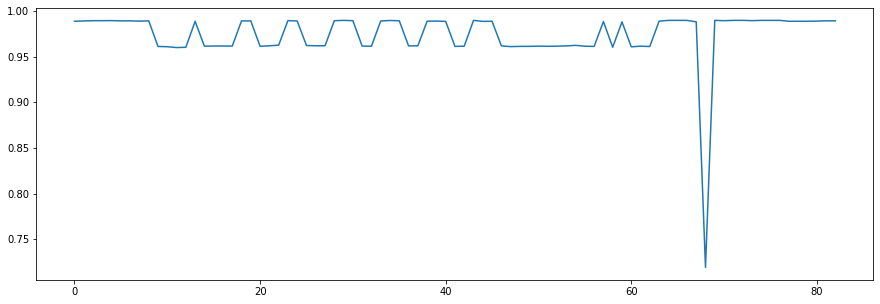

In [62]:
y_ = list(map(lambda x: x[0], results))
x_ = [i for i in range(len(y_))] 
plt.figure(figsize=(15, 5))
plt.plot(x_, y_)
plt.savefig('parameters.png')

In [79]:
results

[(0.9889593783489218,
  Pipeline(memory=None,
           steps=[('addprevnextfeatures',
                   <__main__.AddPrevNextFeatures object at 0x7f93b0ee1950>),
                  ('xgbclassifier',
                   XGBClassifier(base_score=0.5, booster=None,
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints=None, learning_rate=0.1,
                                 max_delta_step=0, max_depth=6,
                                 min_child_weight=1, missing=nan,
                                 monotone_constraints=None, n_estimators=200,
                                 n_jobs=4, nthread=4, num_parallel_tree=1,
                                 objective='multi:softprob', random_state=0,
                                 reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
       

In [74]:
res = results.copy()

In [77]:
del res[68]

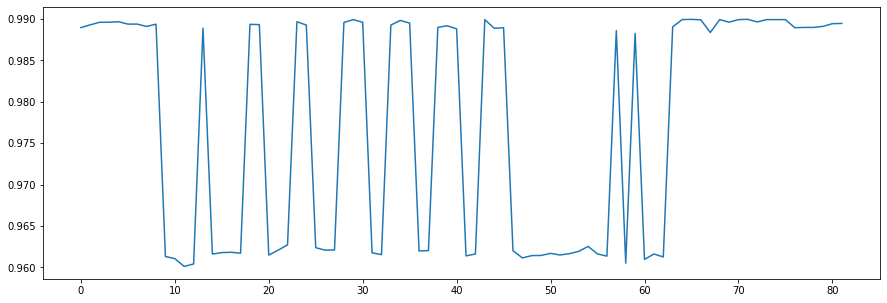

In [78]:
y_ = list(map(lambda x: x[0], res))
x_ = [i for i in range(len(y_))] 
plt.figure(figsize=(15, 5))
plt.plot(x_, y_)
plt.savefig('parameters.png')